In [40]:
import pandas as pd
import pickle,os, copy
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys


import re

from sklearn.cluster import DBSCAN


from deep_generalizability.nets import Nets
from deep_generalizability.utils import *
from deep_generalizability.postprocessing.postprocessing import *
from deep_generalizability.postprocessing.stats_plotting import *
from deep_generalizability.save_load import *

from deep_generalizability.postprocessing.sharpness_measures import *
from deep_generalizability.postprocessing.stats_plotting import *

from deep_generalizability.data_getters import *

%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (13,9)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# add random data to data_getter
# Put a model in a folder. Maybe train for 0 steps. or train on random data. 
# we should now be able to use everything simply.

# Try to test our stuff on more complicated models. VGG or AlexNet. The pretrained ones for now? 

In [29]:
root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
data_name = "MNIST"
exp = "Large_Single_LeNet_cross-entropy"
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp)

In [30]:
stats_df = get_end_stats(experiment_folder, step=10001)


In [170]:
stats_df.sort_values(by="Acc Test Max", ascending=False)

,Acc Gap Mean,Acc Test Max,Acc Test Mean,Acc Test Min,Acc Train Max,Acc Train Mean,Acc Train Min,Loss Test Max,Loss Test Mean,Loss Test Min,Loss Train Max,Loss Train Mean,Loss Train Min,Norm Max,Norm Mean,Norm Min
1599422489.5739546,-0.0022,0.886,0.886,0.886,0.8882,0.8882,0.8882,0.280093,0.280093,0.280093,0.25841,0.25841,0.25841,17.566751,17.566751,17.566751


In [121]:
point_traces, meta = load_cached_data(experiment_folder, "point_traces", step=-1)

In [213]:
margin_filters = get_exp_margins(experiment_folder, softmax_outputs=False, step=-1, seed=0, device=None, num_datapoints=100, on_test_set=False, should_cache=False)


In [214]:
linear_loss_trace_filters = get_exp_linear_loss_trace(experiment_folder, step=-1, seed=0, device=None, num_datapoints=100, on_test_set=False, should_cache=False)


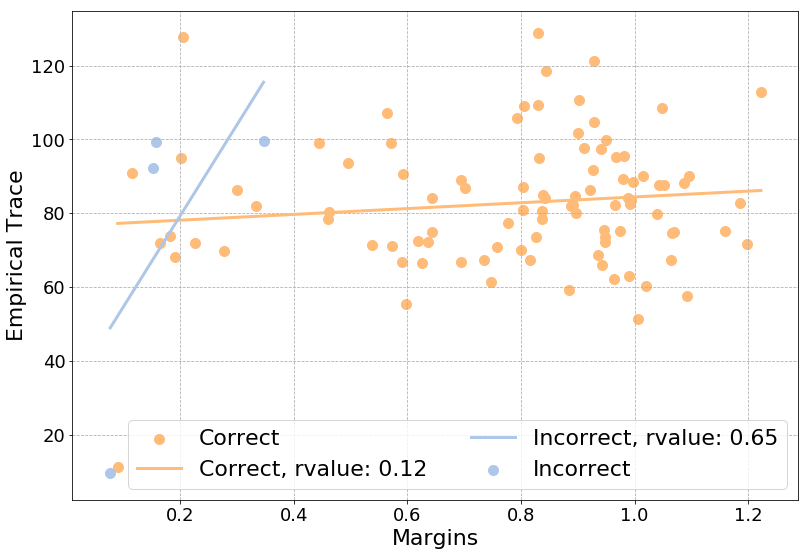

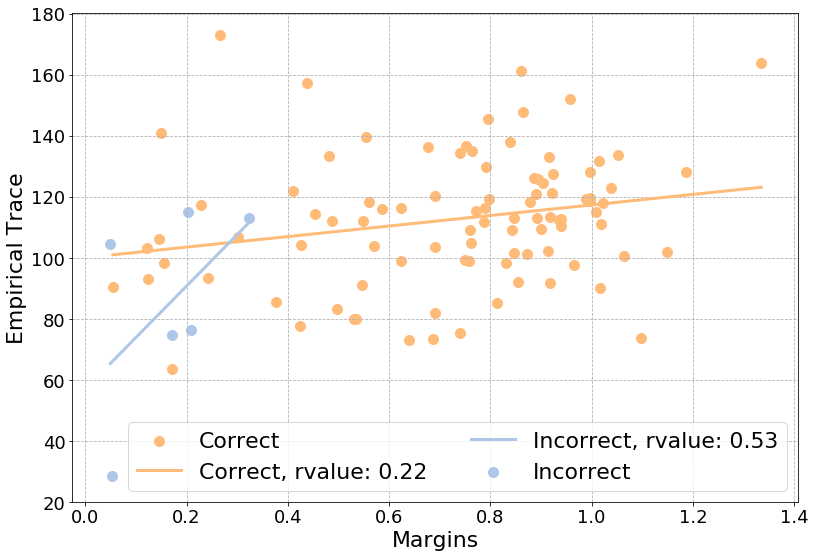

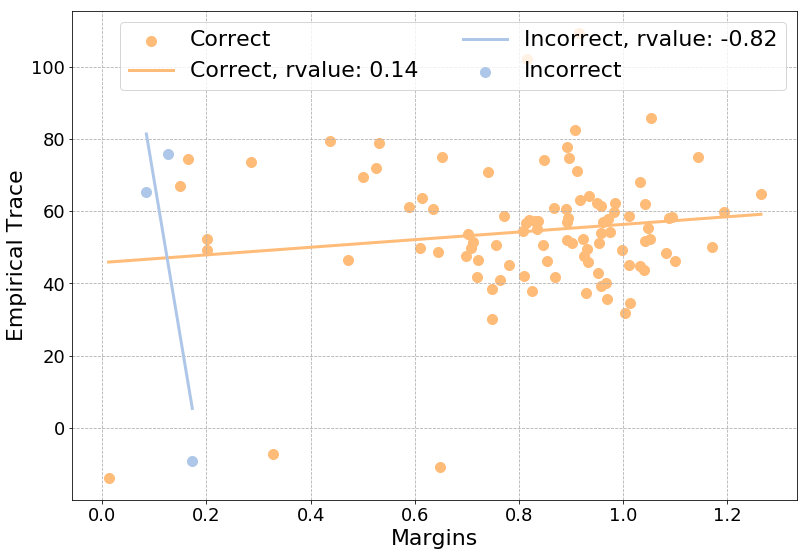

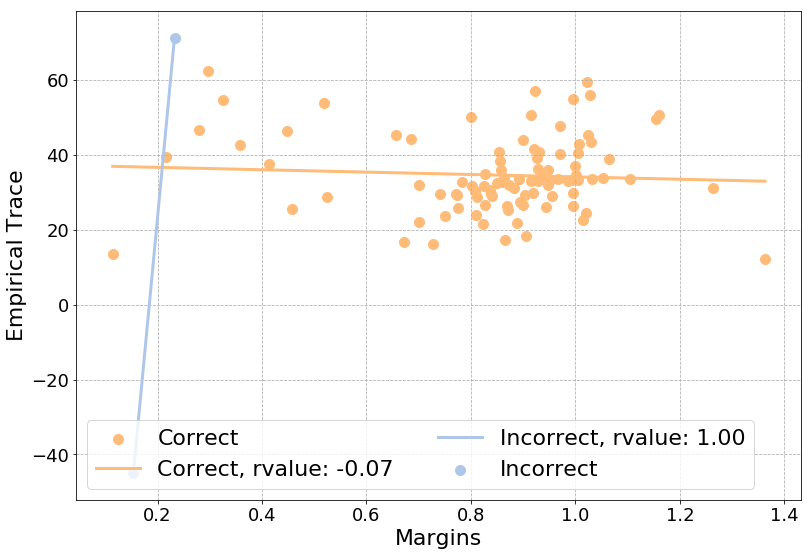

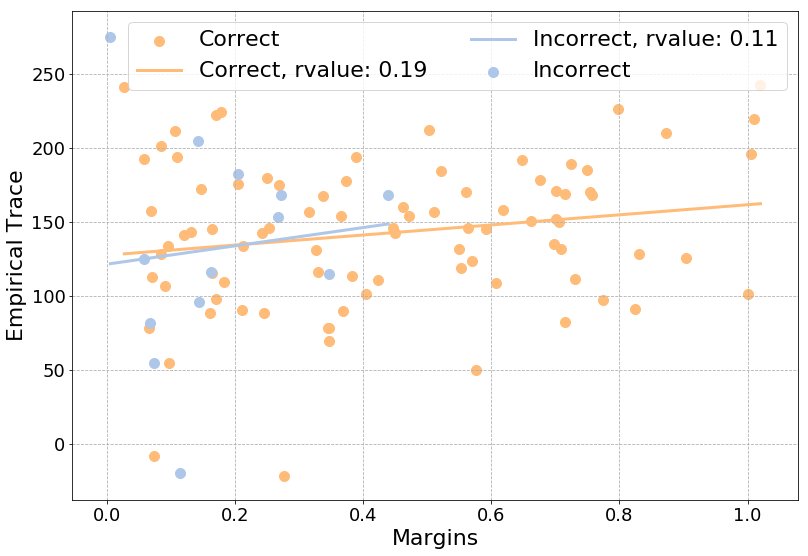

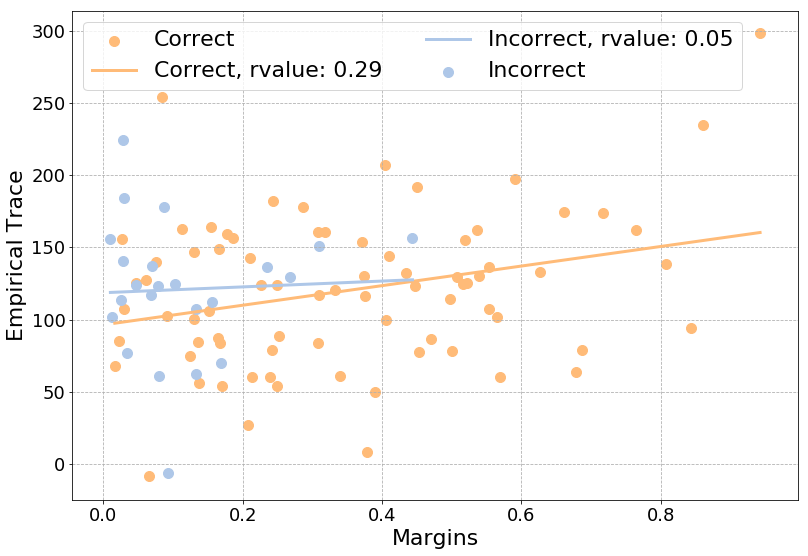

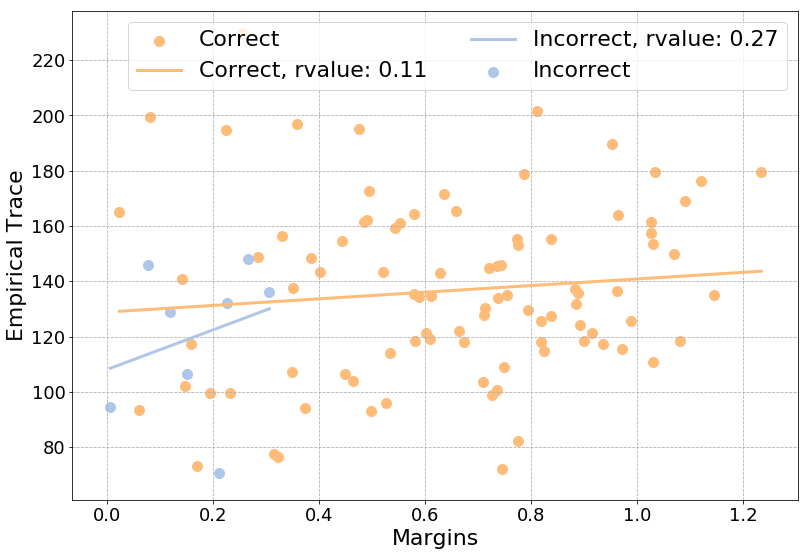

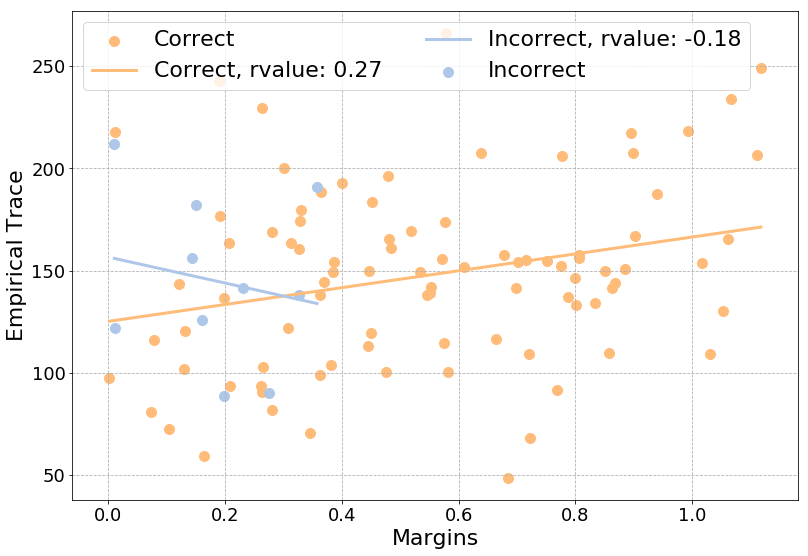

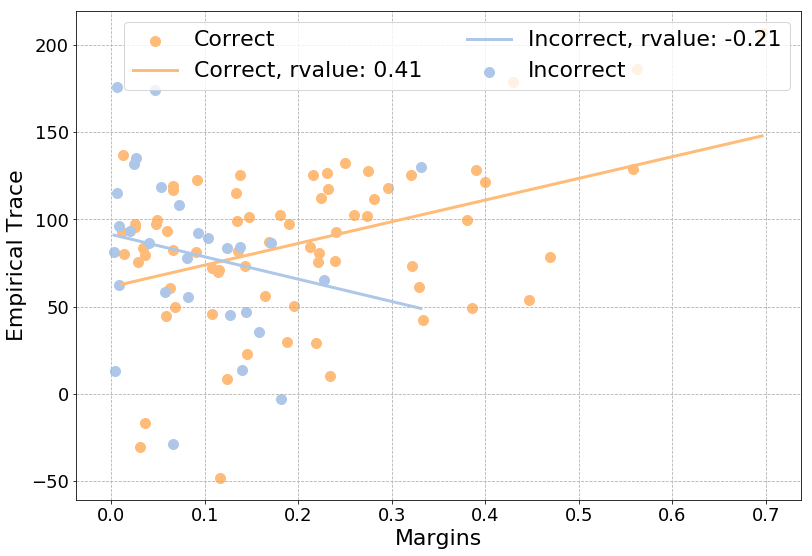

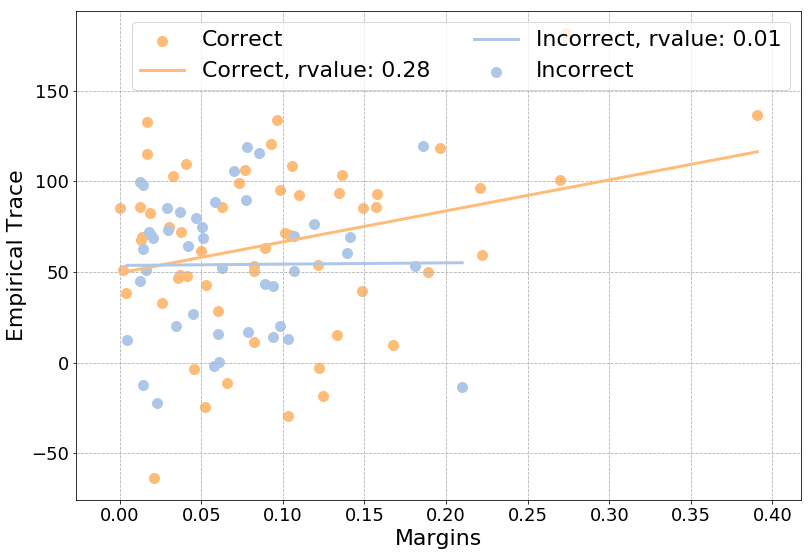

In [186]:

# Plot trace vs margins
X_axis_name = "Margins"
Y_axis_name = "Empirical Trace"


plot_name = "Correct_Incorrect"
X_axis_bounds = None
Y_axis_bounds = None

save_exp_path = experiment_folder

filter_seperate = ["learning_rate"]
filter_not_seperate = None

pre_filtered_exp_ids = None

use_correct_filter = True
draw_correlation = True

data_func = margin_trace_correct_incorrect_plot(margin_filters, point_traces, use_correct_filter=use_correct_filter, draw_correlation=draw_correlation)

hp_data_func_plot(experiment_folder, data_func, X_axis_name, Y_axis_name, 
                  plot_name, filter_seperate, filter_not_seperate,
                 save_exp_path, X_axis_bounds, Y_axis_bounds, 
                    pre_filtered_exp_ids)



In [31]:
all_steps = get_exp_steps(experiment_folder)
all_steps = np.array([list(v.keys()) for v in all_steps.values()]).reshape(-1)
all_steps = sorted(list(set(all_steps)))

In [32]:
# Plot trace vs margins
X_axis_name = "ACEHT"
Y_axis_name = "Empirical Trace"


plot_name = "C_IC"
X_axis_bounds = None
Y_axis_bounds = None


filter_seperate = ["learning_rate"]
filter_not_seperate = None

pre_filtered_exp_ids = None

use_correct_filter = True
draw_correlation = True



0
{'1599422489.5739546': {'0': (0.1016, 0.1068)}}


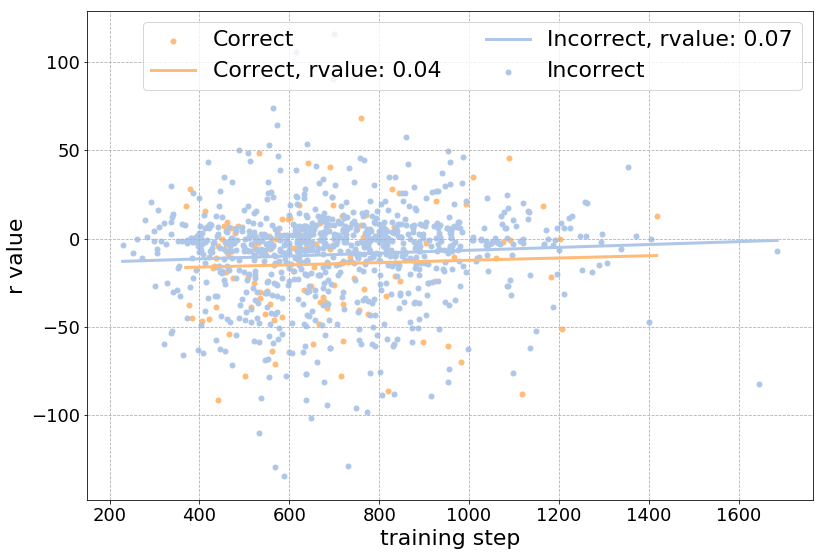

1
{'1599422489.5739546': {'0': (0.115, 0.1242)}}


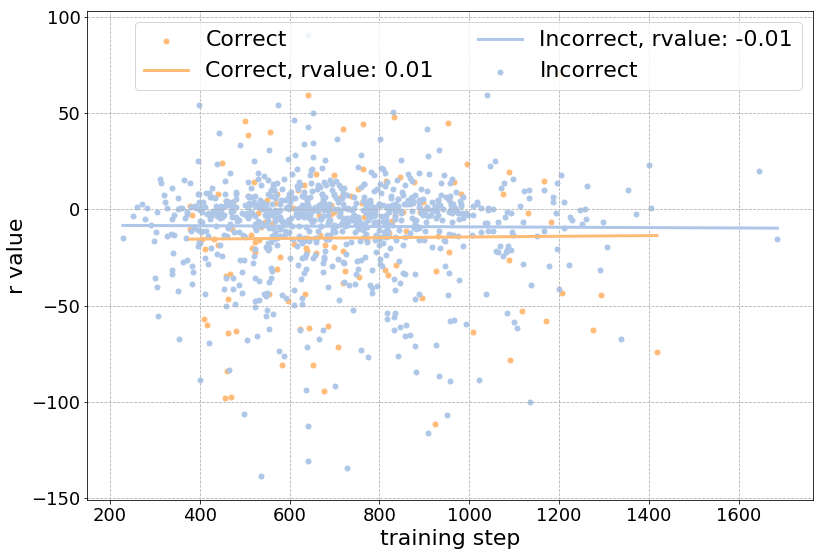

251
{'1599422489.5739546': {'0': (0.6692, 0.6766)}}


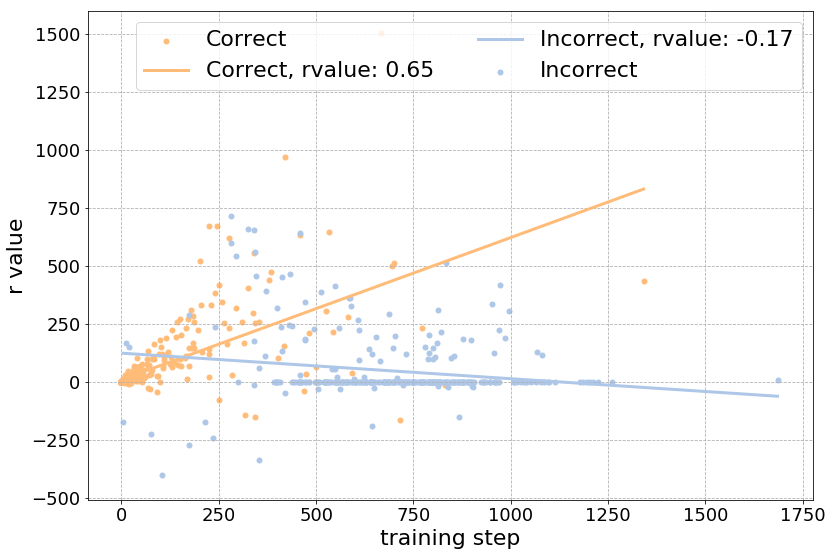

501
{'1599422489.5739546': {'0': (0.6828, 0.6886)}}


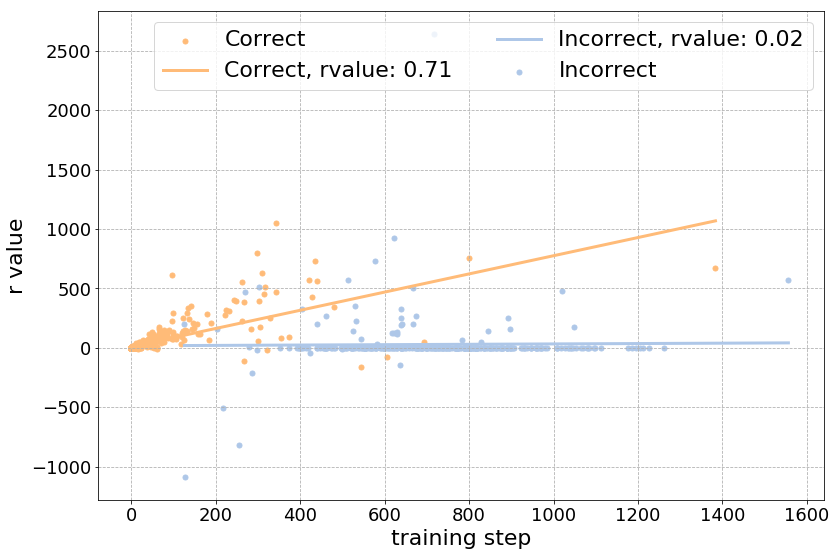

751
{'1599422489.5739546': {'0': (0.6844, 0.692)}}


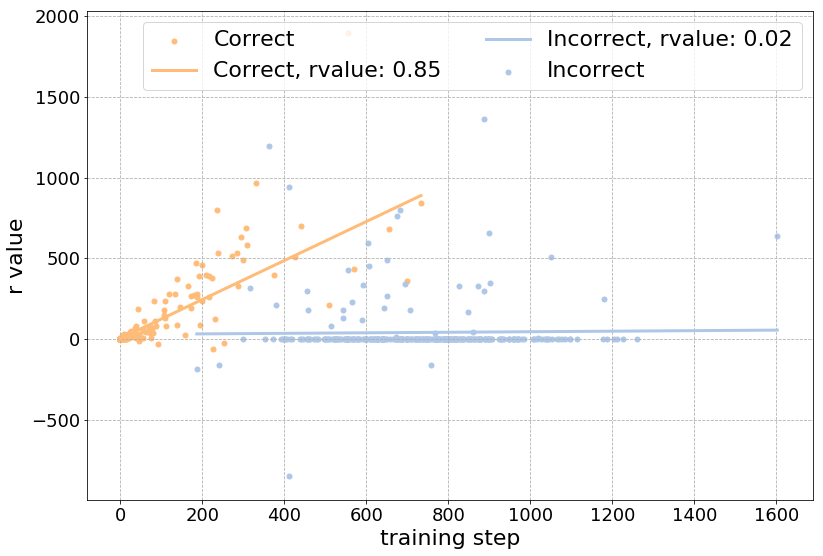

1001
{'1599422489.5739546': {'0': (0.7804, 0.7908)}}


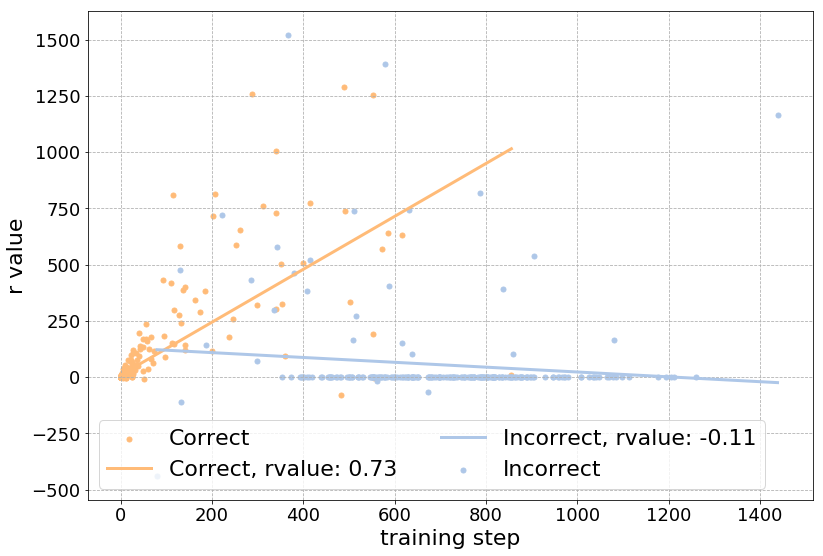

1251
{'1599422489.5739546': {'0': (0.7796, 0.7908)}}


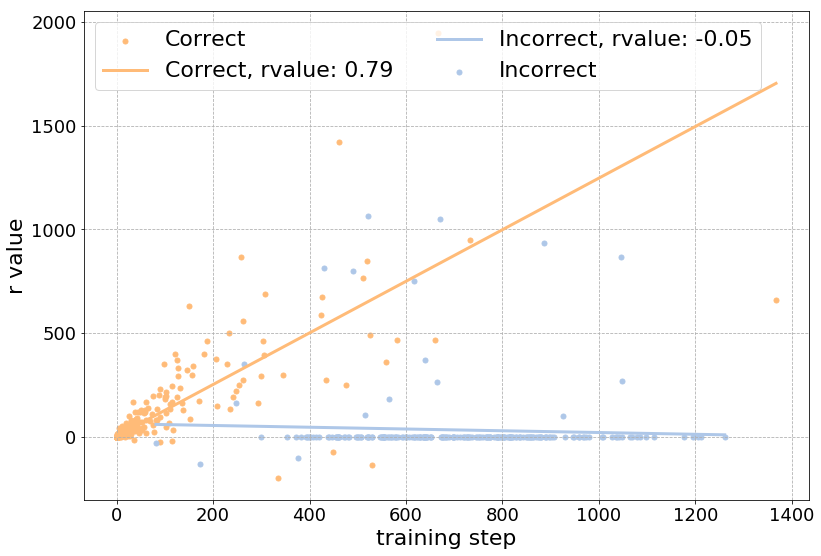

1501
{'1599422489.5739546': {'0': (0.783, 0.7942)}}


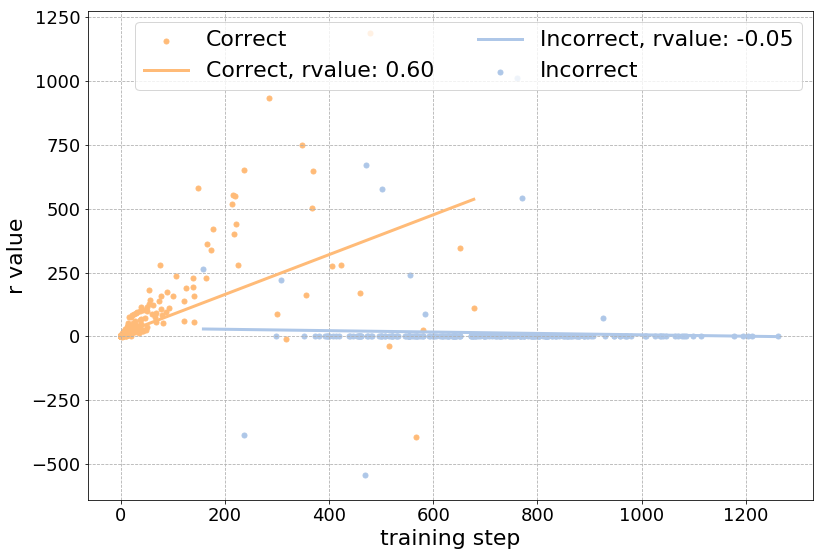

1751
{'1599422489.5739546': {'0': (0.7828, 0.7896)}}


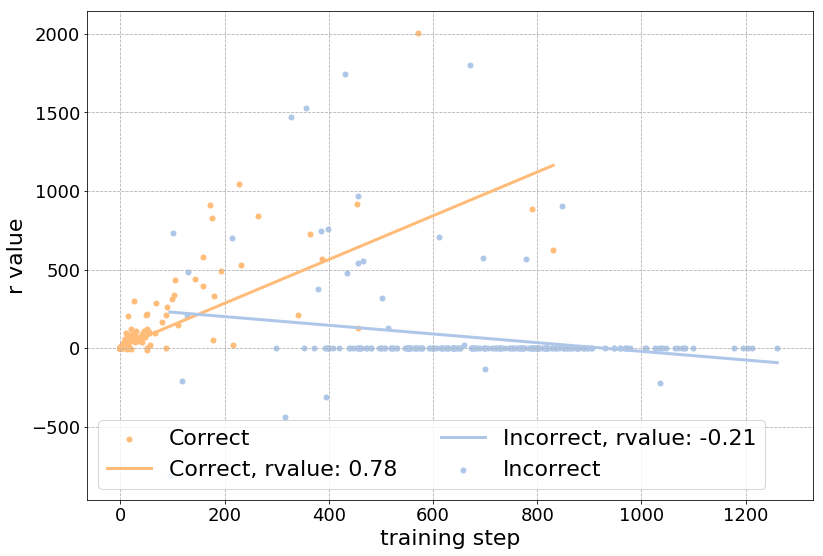

2001
{'1599422489.5739546': {'0': (0.7856, 0.7928)}}


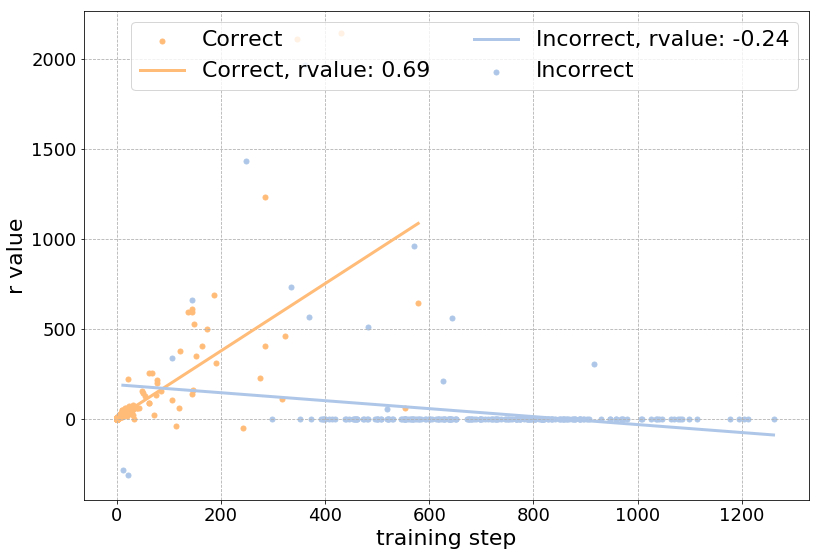

2251
{'1599422489.5739546': {'0': (0.785, 0.7934)}}


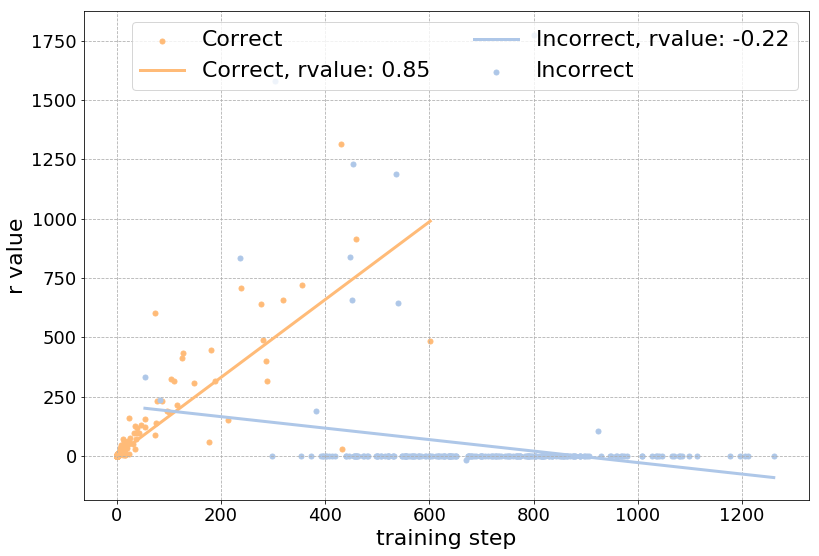

2501
{'1599422489.5739546': {'0': (0.7856, 0.7924)}}


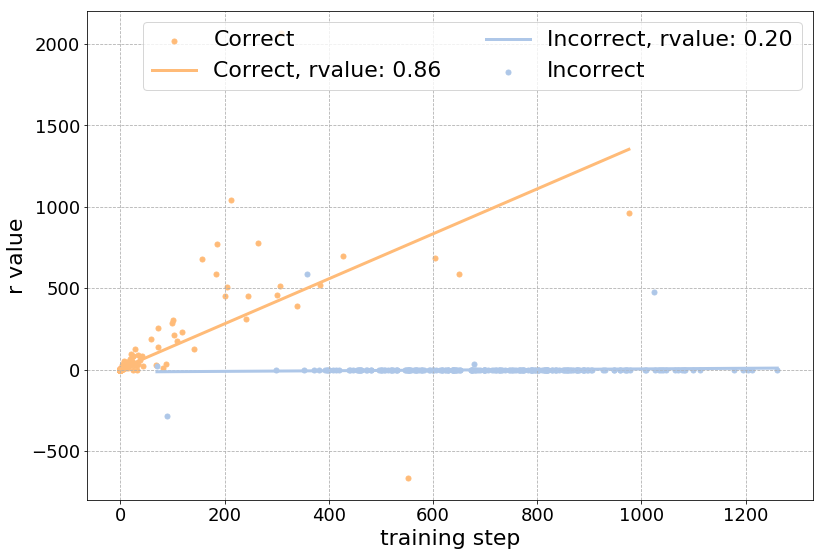

2751
{'1599422489.5739546': {'0': (0.8834, 0.8856)}}


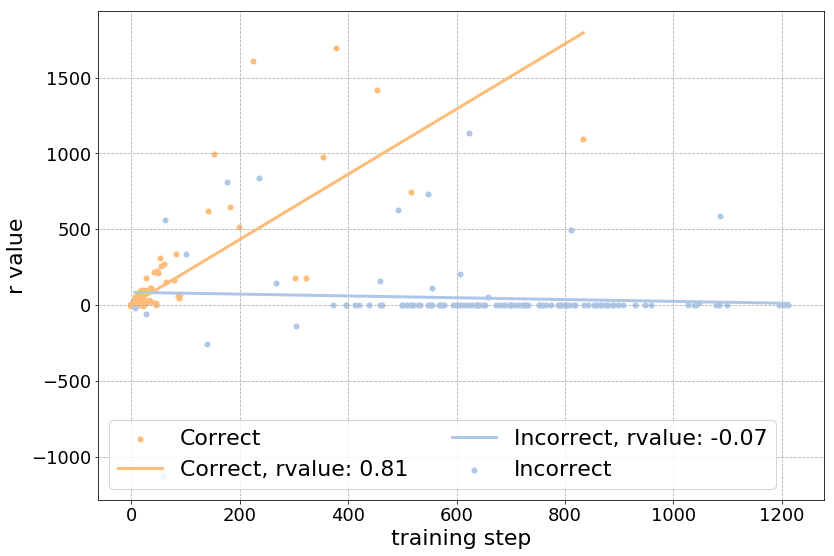

3001
{'1599422489.5739546': {'0': (0.881, 0.881)}}


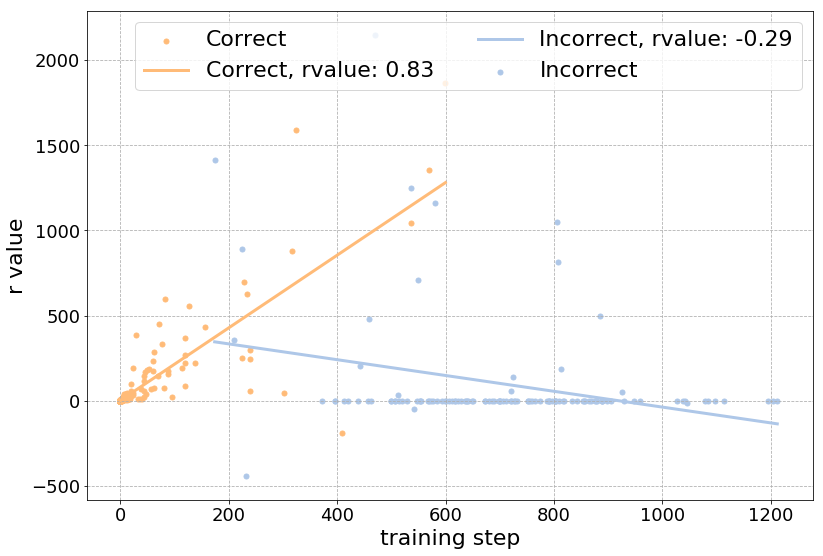

3251
{'1599422489.5739546': {'0': (0.8786, 0.8822)}}


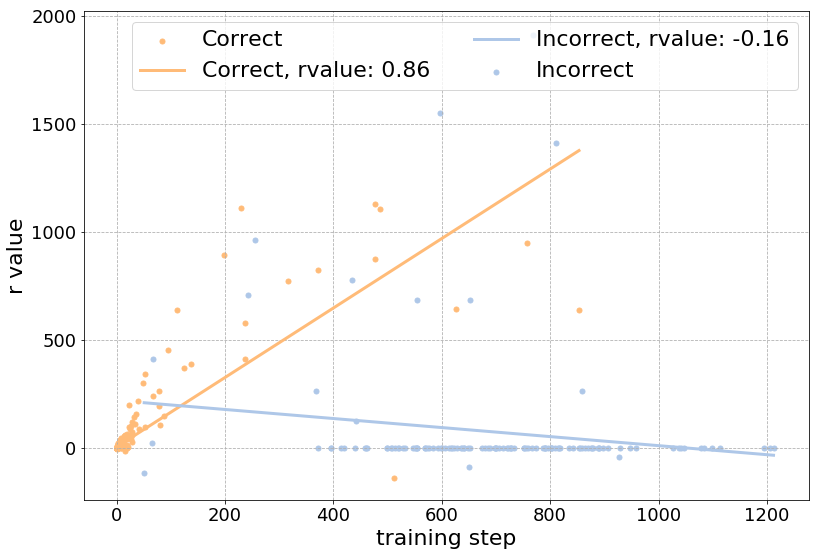

3501
{'1599422489.5739546': {'0': (0.8856, 0.8864)}}


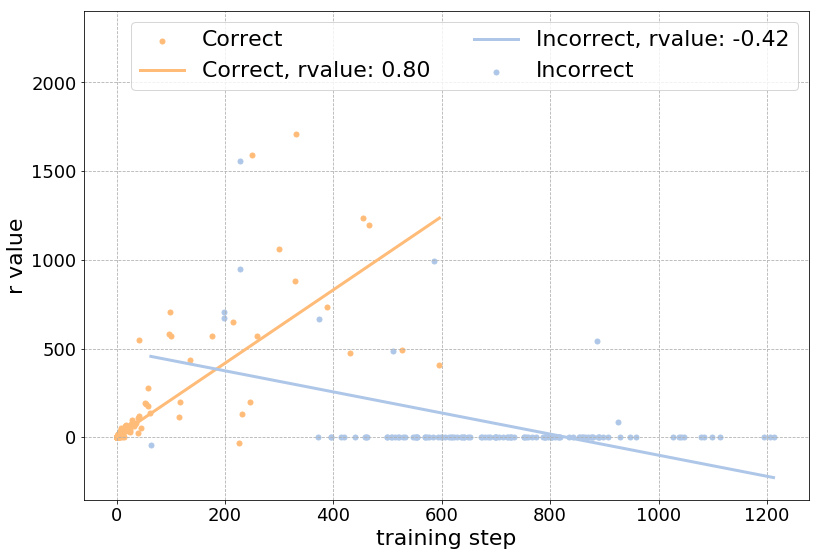

3751
{'1599422489.5739546': {'0': (0.8782, 0.8816)}}


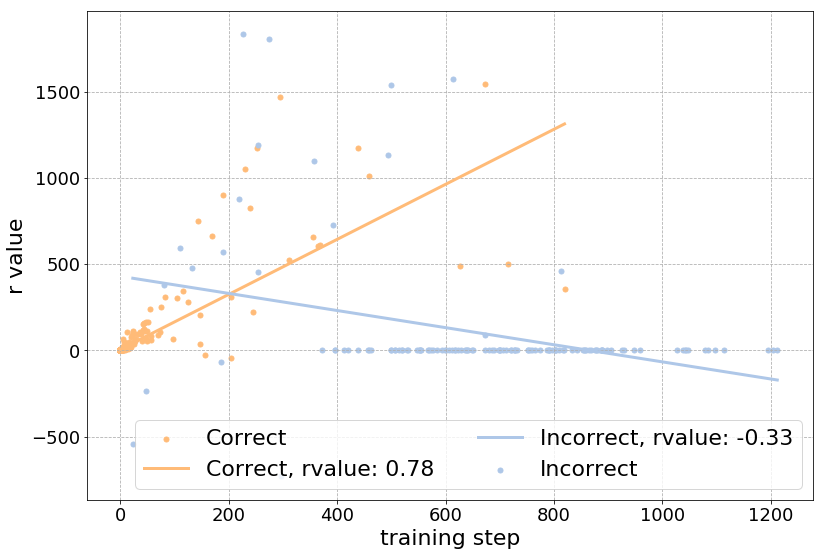

4001
{'1599422489.5739546': {'0': (0.8876, 0.8882)}}


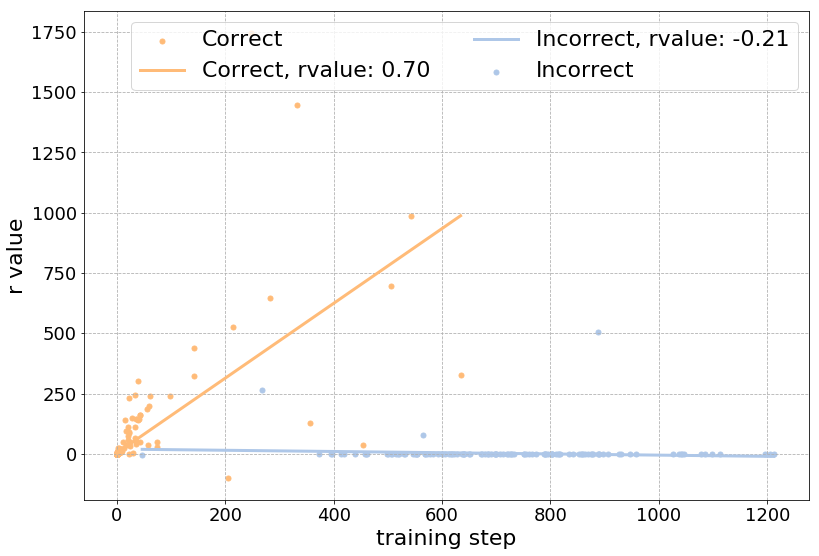

4251
{'1599422489.5739546': {'0': (0.8836, 0.8802)}}


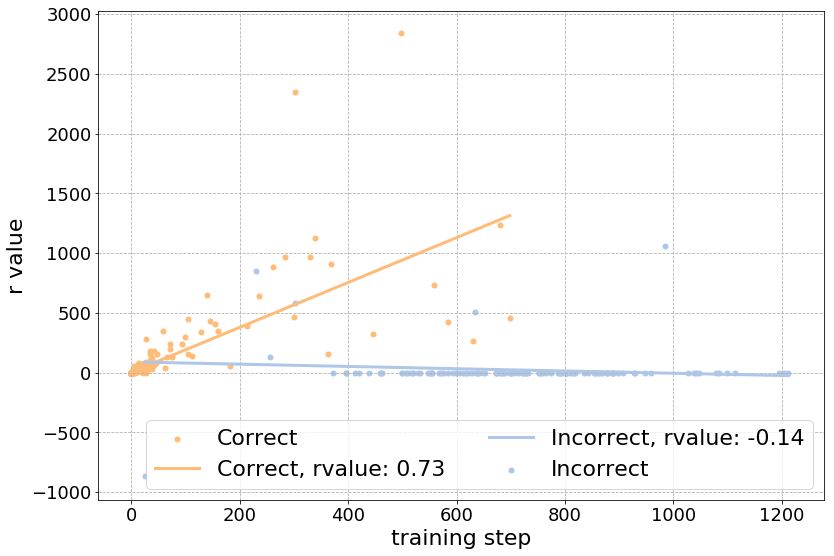

4501
{'1599422489.5739546': {'0': (0.885, 0.8858)}}


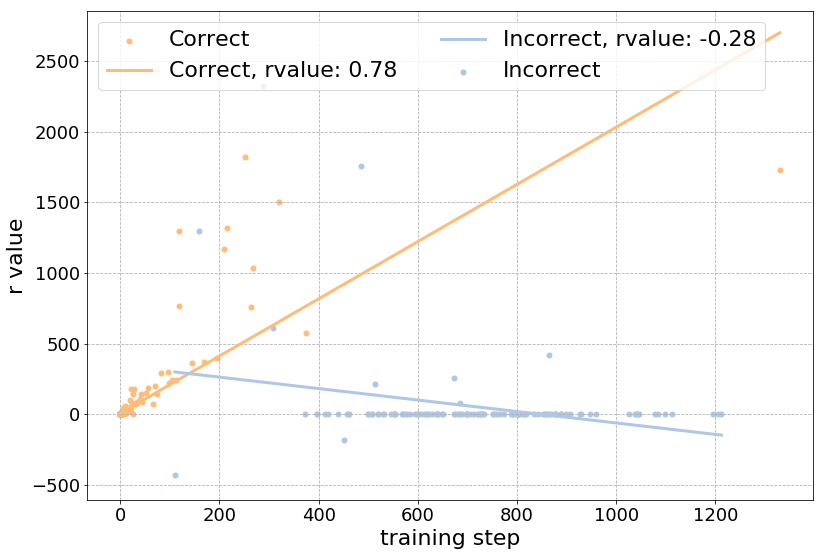

4751
{'1599422489.5739546': {'0': (0.887, 0.8888)}}


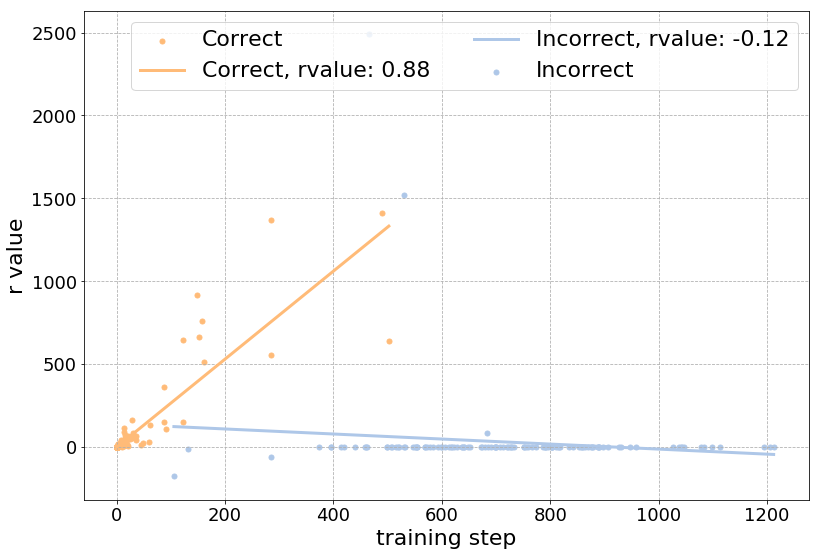

5001
{'1599422489.5739546': {'0': (0.888, 0.8882)}}


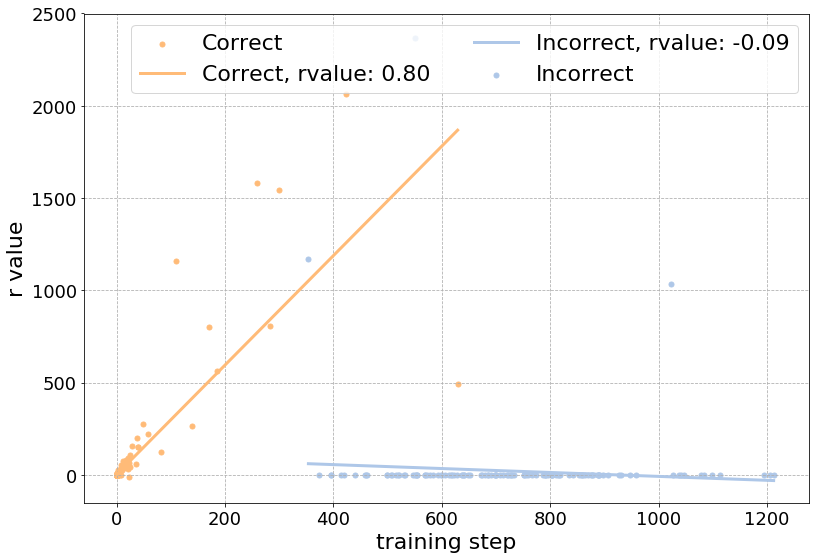

5251
{'1599422489.5739546': {'0': (0.8852, 0.887)}}


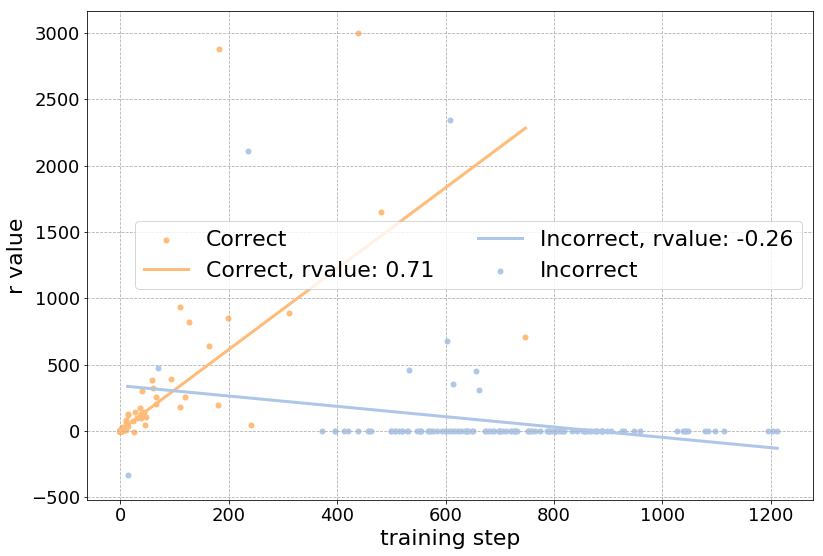

5501
{'1599422489.5739546': {'0': (0.8868, 0.8846)}}


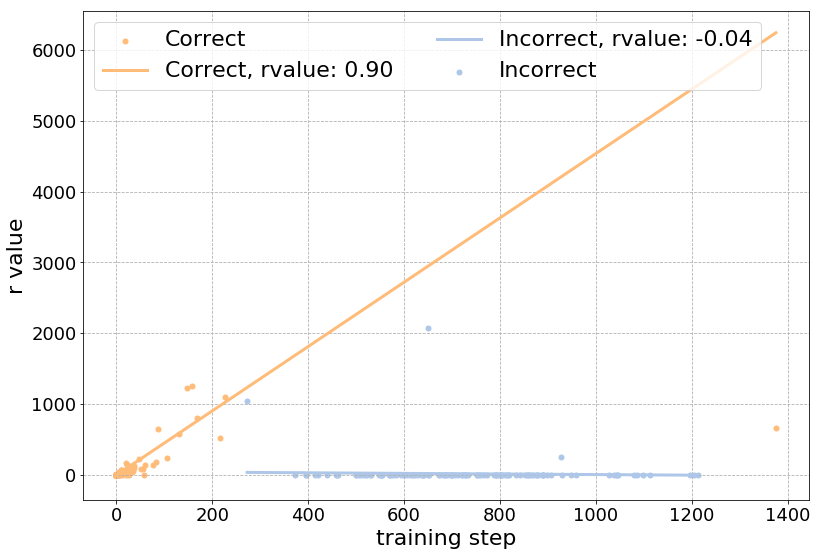

5751
{'1599422489.5739546': {'0': (0.8882, 0.8874)}}


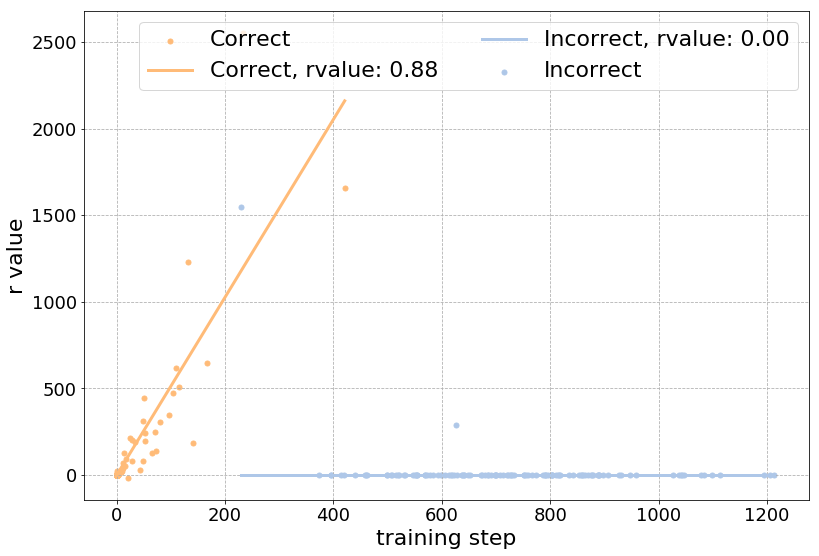

6001
{'1599422489.5739546': {'0': (0.8876, 0.8856)}}


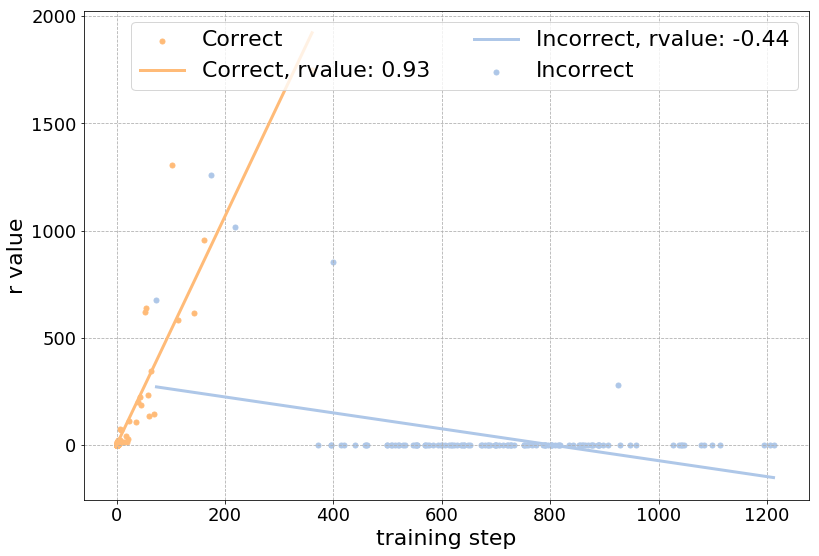

6251
{'1599422489.5739546': {'0': (0.8866, 0.8836)}}


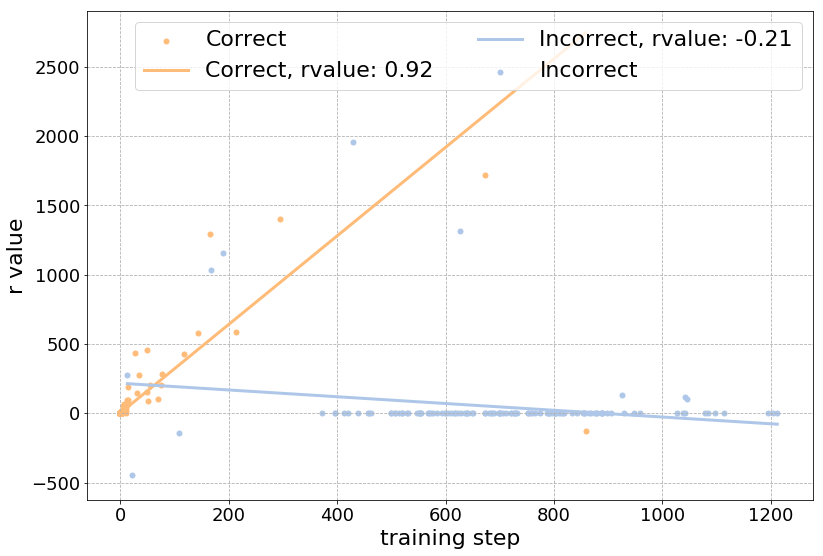

6501
{'1599422489.5739546': {'0': (0.8868, 0.8852)}}


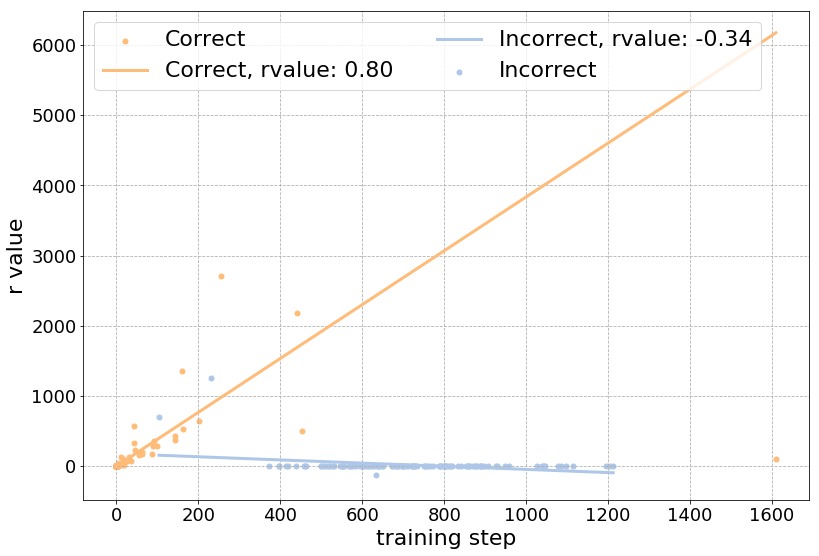

6751
{'1599422489.5739546': {'0': (0.8872, 0.8826)}}


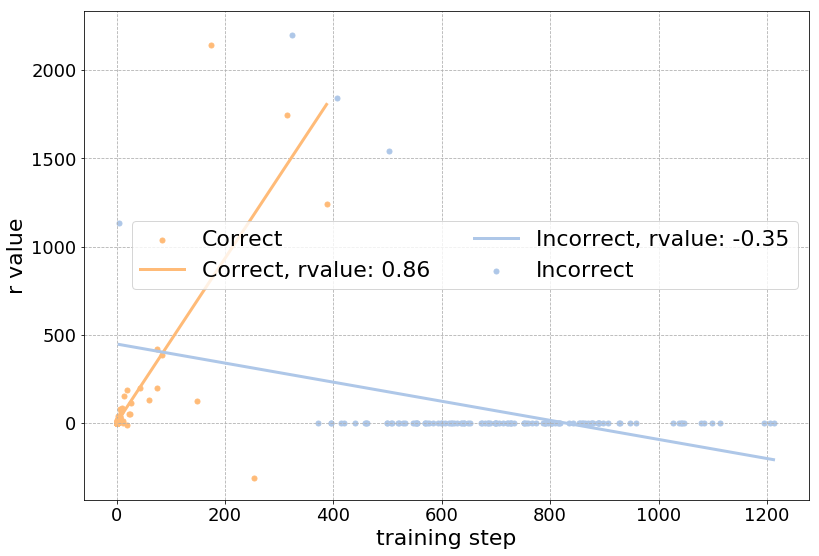

7001
{'1599422489.5739546': {'0': (0.8876, 0.8864)}}


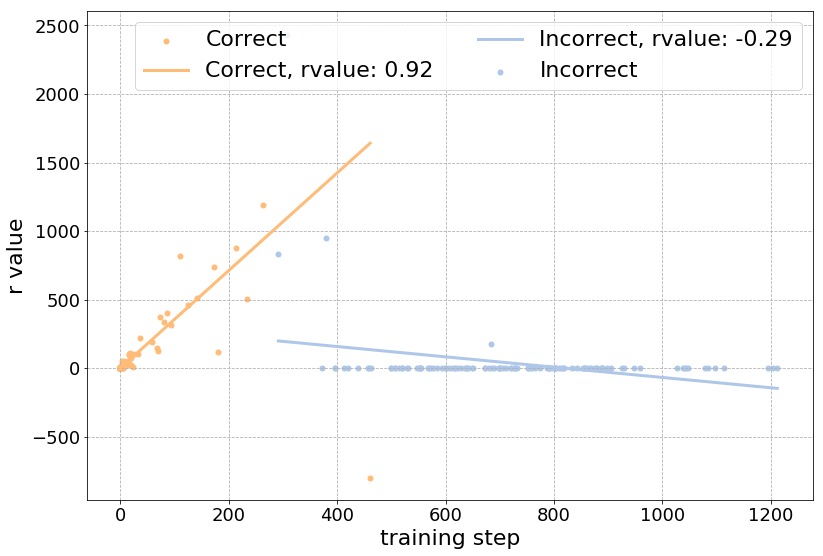

7251
{'1599422489.5739546': {'0': (0.8878, 0.8862)}}


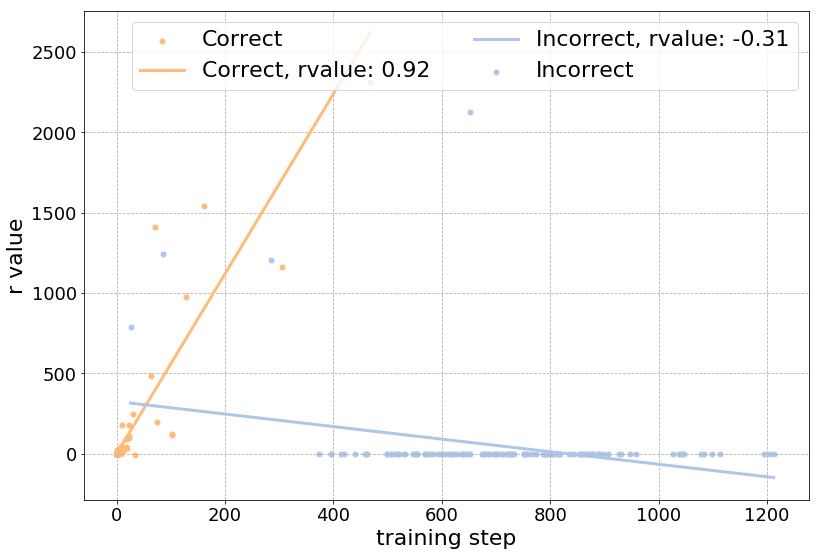

7501
{'1599422489.5739546': {'0': (0.8866, 0.8864)}}


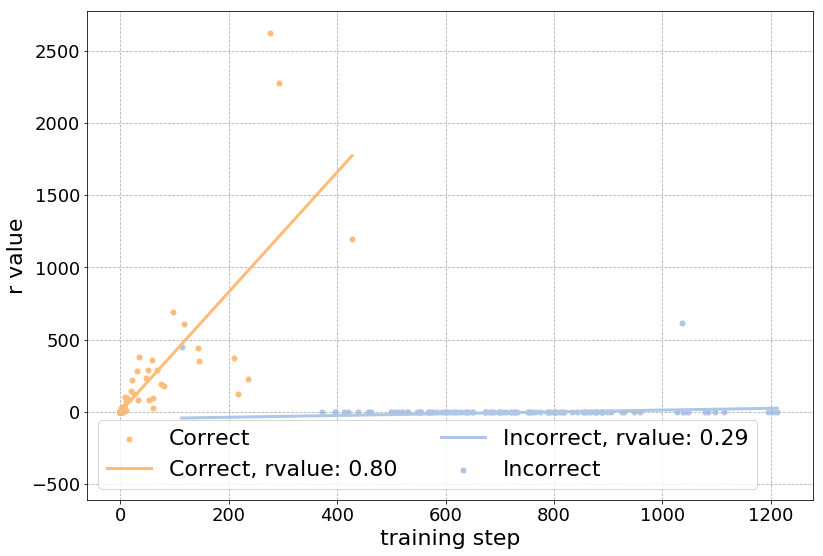

7751
{'1599422489.5739546': {'0': (0.8876, 0.8852)}}


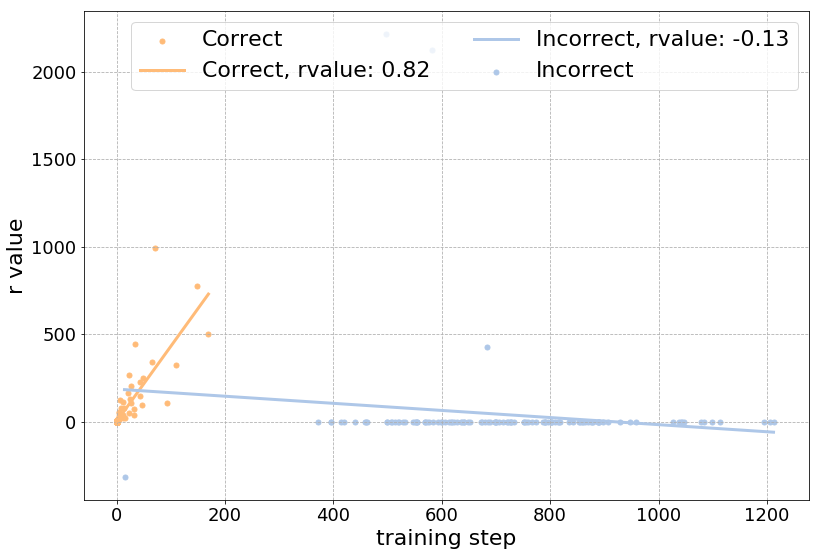

8001
{'1599422489.5739546': {'0': (0.888, 0.8878)}}


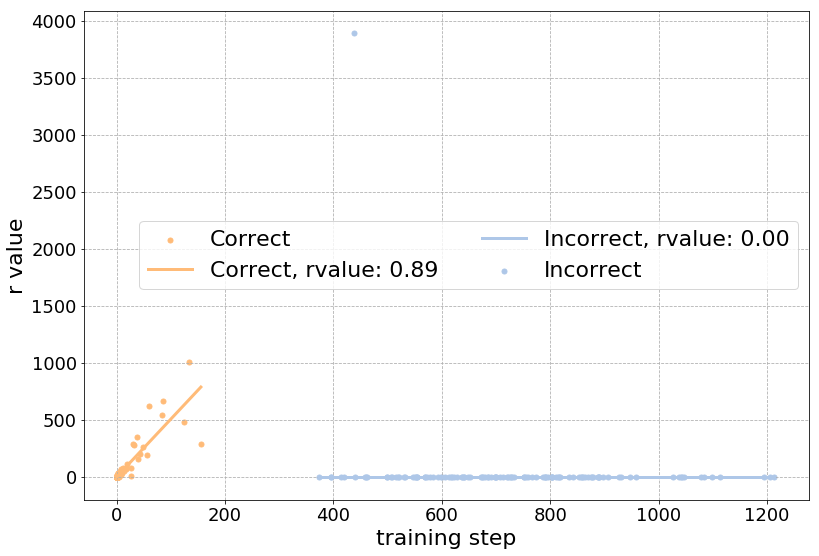

8251
{'1599422489.5739546': {'0': (0.8824, 0.881)}}


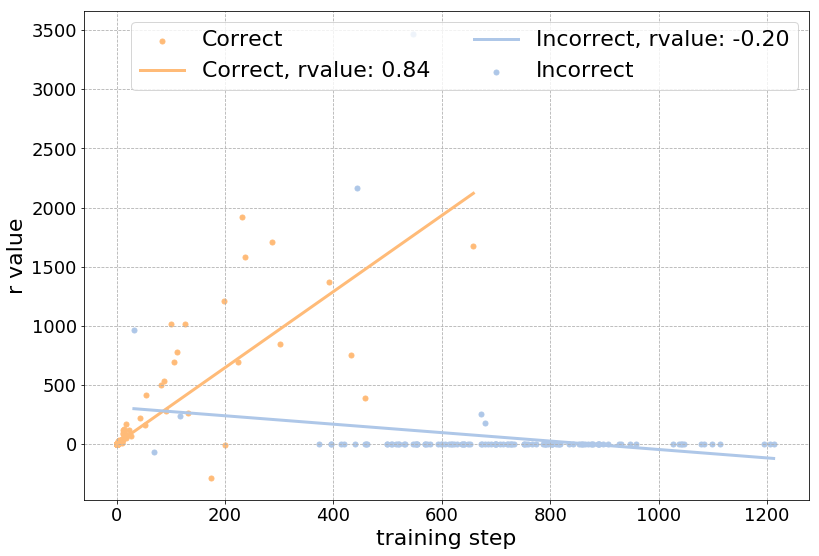

8501
{'1599422489.5739546': {'0': (0.887, 0.8862)}}


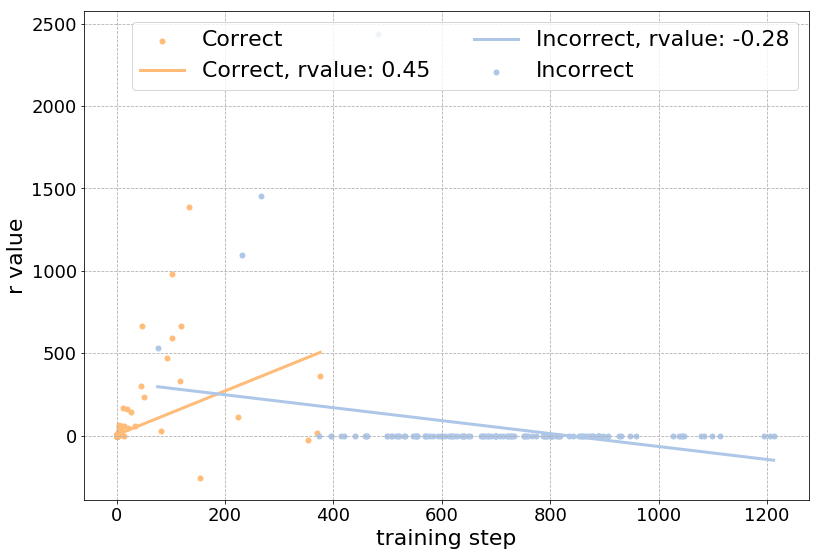

8751
{'1599422489.5739546': {'0': (0.888, 0.8886)}}


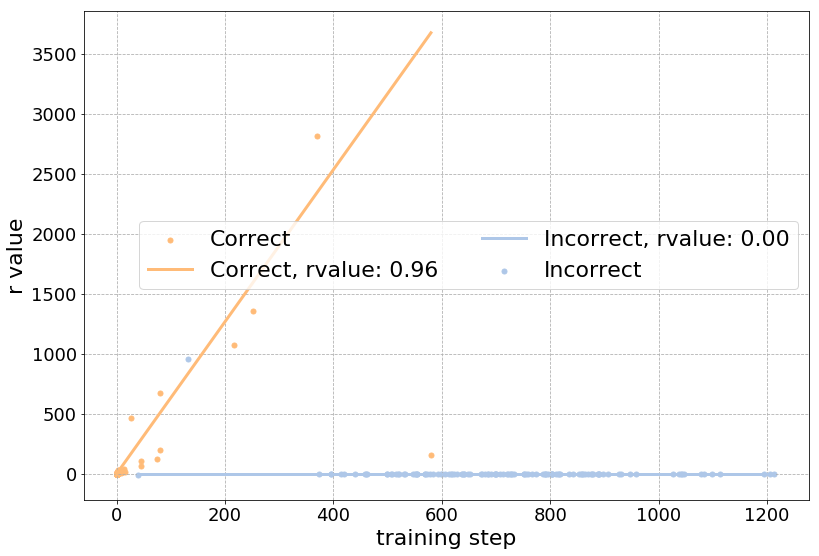

9001
{'1599422489.5739546': {'0': (0.8886, 0.8864)}}


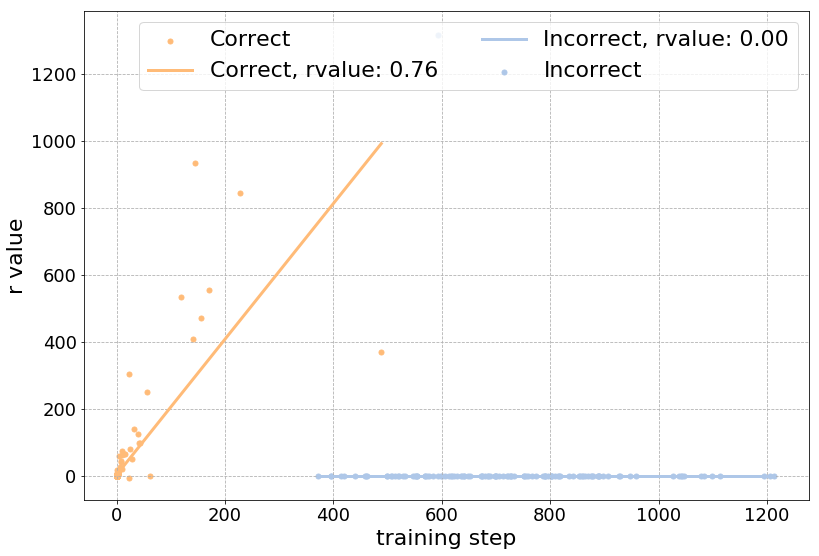

9251
{'1599422489.5739546': {'0': (0.8894, 0.8864)}}


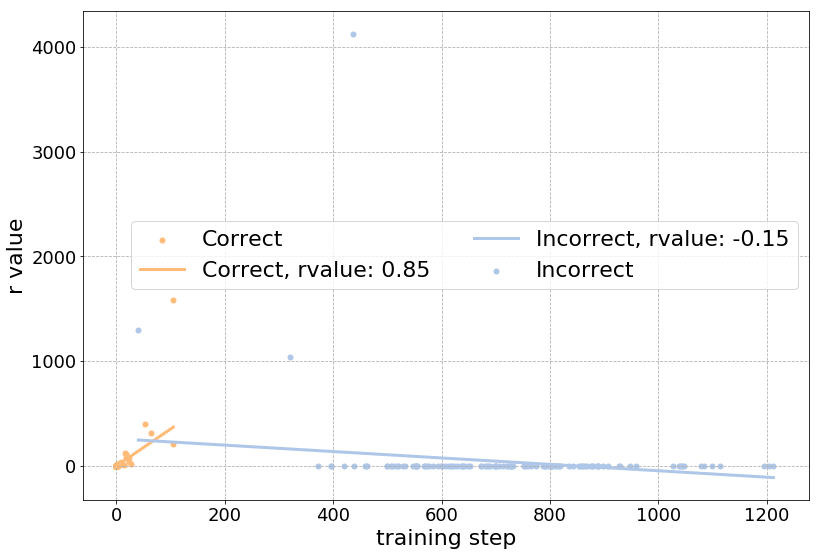

9501
{'1599422489.5739546': {'0': (0.8886, 0.8844)}}


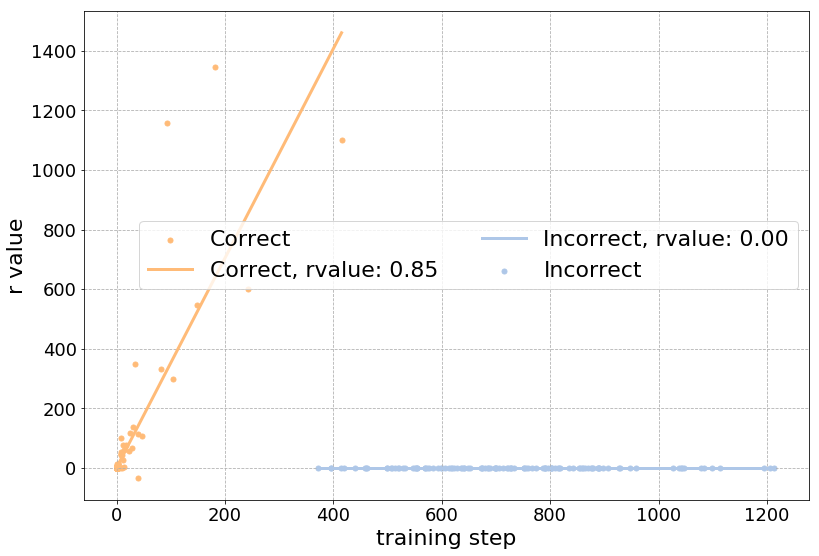

9751
{'1599422489.5739546': {'0': (0.8894, 0.8868)}}


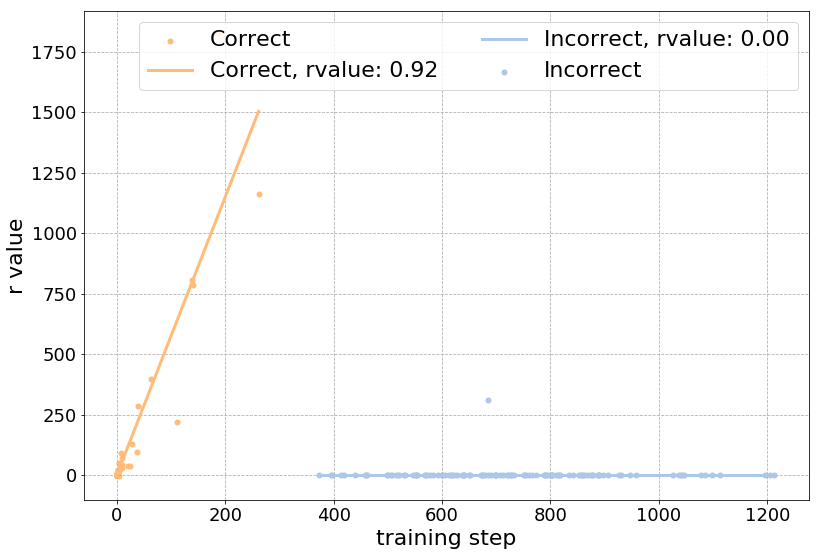

10001
{'1599422489.5739546': {'0': (0.8882, 0.886)}}


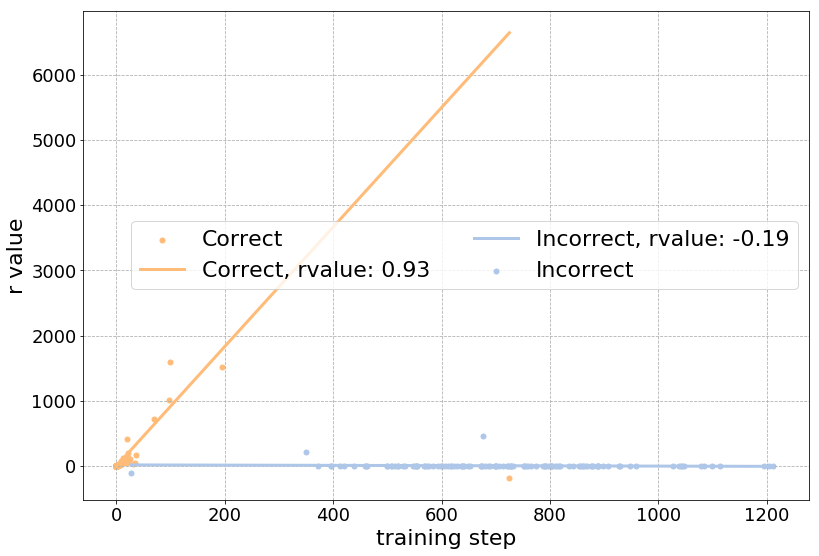

In [55]:
save_time_path = os.path.join(experiment_folder, "time_corr")
if not os.path.isdir(save_time_path):
    os.mkdir(save_time_path)

for step in all_steps:
    print(step)
    acc, _ = load_cached_data(experiment_folder, "acc", step=step)
    print(acc)
    
    curr_point_traces, meta = load_cached_data(experiment_folder, "point_traces", step=step)
    linear_loss_trace_filters = get_exp_linear_loss_trace(experiment_folder, step=step, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)
#     linear_loss_trace_filters = get_exp_margins(experiment_folder, softmax_outputs=False, step=step, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)
    
    curr_plot_name = "{}_step_{}".format(plot_name, step)
    
    data_func = margin_trace_correct_incorrect_plot(linear_loss_trace_filters, curr_point_traces, use_correct_filter=use_correct_filter, draw_correlation=draw_correlation)
    
    hp_data_func_plot(experiment_folder, data_func, X_axis_name, Y_axis_name, 
                      curr_plot_name, filter_seperate, filter_not_seperate,
                 save_time_path, X_axis_bounds, Y_axis_bounds, 
                    pre_filtered_exp_ids)



In [56]:
def get_corr_array(experiment_folder, X_data_filter_f, Y_data_f, use_correct_filter):
    all_steps = get_exp_steps(experiment_folder)
    all_steps = np.array([list(v.keys()) for v in all_steps.values()]).reshape(-1)
    all_steps = sorted(list(set(all_steps)))
    
    exp_cfgs = load_configs(experiment_folder)
    exp_ids = exp_cfgs.index
    
    res_dict = {}
    
    for step in all_steps:

        X_data_filter = X_data_filter_f(step)
        Y_data = Y_data_f(step)
        
        for exp_id in exp_ids:
            if exp_id not in res_dict:
                res_dict[exp_id] = {}
            
            for model_idx in range(exp_cfgs.loc[exp_id]["num_nets"]):
                model_idx = str(model_idx)
                if model_idx not in res_dict[exp_id]:
                    res_dict[exp_id][model_idx] = {}
                    res_dict[exp_id][model_idx]["acc"] = {} 
                    if use_correct_filter:
                        res_dict[exp_id][model_idx]["correct_r_value"] = {}
                        res_dict[exp_id][model_idx]["incorrect_r_value"] = {}
                    else:
                        res_dict[exp_id][model_idx]["r_value"] = {}
                    
                curr_X_data, correct_filter = X_data_filter[exp_id][model_idx]
                curr_Y_data = np.array(Y_data[exp_id][model_idx])
                if use_correct_filter:
                    slope, intercept, correct_r_value, _, _ = linregress_outliers(curr_X_data[correct_filter], curr_Y_data[correct_filter])
                    res_dict[exp_id][model_idx]["correct_r_value"][step] = correct_r_value

                    slope, intercept, incorrect_r_value, _, _ = linregress_outliers(curr_X_data[~correct_filter], curr_Y_data[~correct_filter])
                    res_dict[exp_id][model_idx]["incorrect_r_value"][step] = incorrect_r_value
                else:
                    slope, intercept, r_value, _, _ = linregress_outliers(curr_X_data, curr_Y_data)
                    res_dict[exp_id][model_idx]["r_value"][step] = r_value
                res_dict[exp_id][model_idx]["acc"][step] =  sum(1*correct_filter)/float(len(correct_filter))
    return res_dict

                    
X_data_filter_f = lambda step: get_exp_linear_loss_trace(experiment_folder, step=step, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)
Y_data_f = lambda step:  load_cached_data(experiment_folder, "point_traces", step=step)[0]
use_correct_filter = True
c = get_corr_array(experiment_folder, X_data_filter_f, Y_data_f, use_correct_filter)


In [57]:
a = c["1599422489.5739546"]["0"]

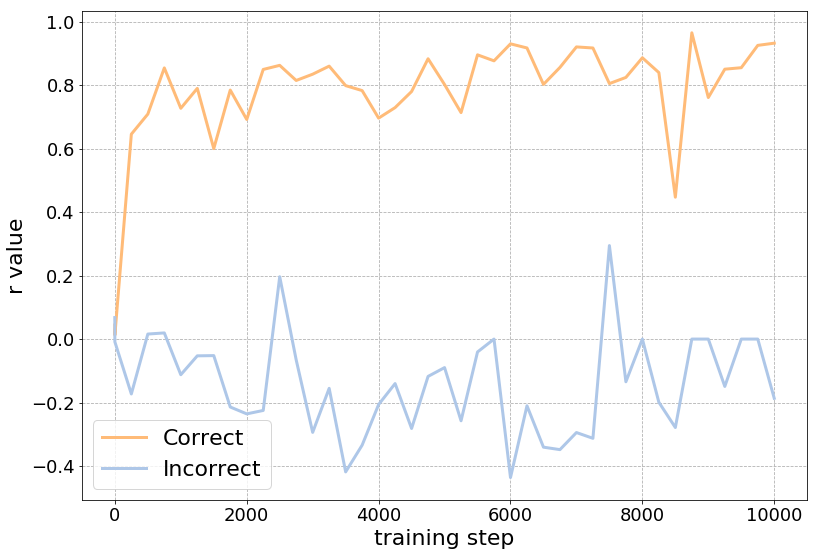

In [58]:
plots = []
plots_names = []
X_axis_name = "training step"
Y_axis_name = "r value"

save_location = os.path.join(experiment_folder, "time_r.png")


plots.append(plt.plot(list(a["correct_r_value"].keys()), list(a["correct_r_value"].values()), label="Correct"))
plots.append(plt.plot(list(a["incorrect_r_value"].keys()), list(a["incorrect_r_value"].values()), label="Incorrect"))

costum_plot(plots, plots_names, X_axis_name, Y_axis_name, X_axis_bounds=None, Y_axis_bounds=None, save_location=save_location)

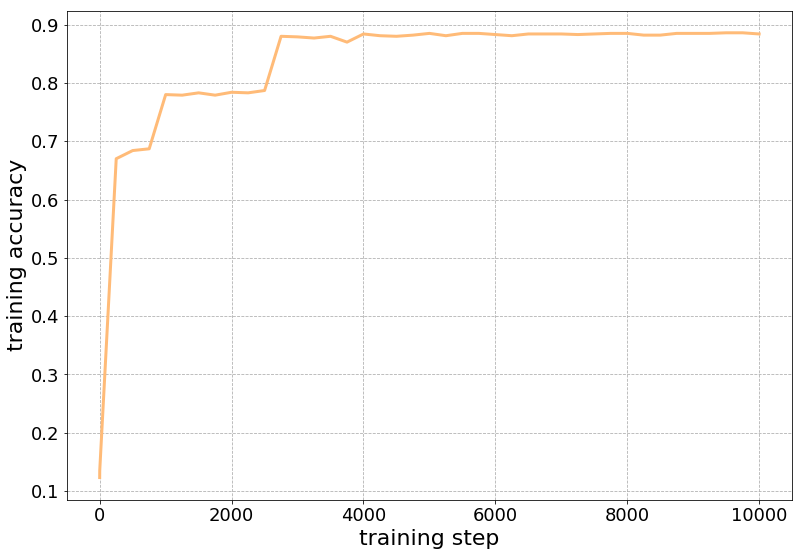

In [59]:
plots = []
plots_names = []
X_axis_name = "training step"
Y_axis_name = "training accuracy"

save_location = os.path.join(experiment_folder, "time_acc.png")


plots.append(plt.plot(list(a["acc"].keys()), list(a["acc"].values())))

costum_plot(plots, plots_names, X_axis_name, Y_axis_name, X_axis_bounds=None, Y_axis_bounds=None, save_location=save_location)



In [62]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

In [61]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [63]:
import torch
from torchvision import datasets, transforms as T



RuntimeError: ('Meta file not found or corrupted.', 'You can use download=True to create it.')

In [65]:
train_data, test_data = get_data(data_name="ImageNet", vectorized=False, reduce_train_per=None, seed=0, meta=None)

HTTPError: HTTP Error 404: Not Found